In [1]:
import sys
sys.path.append('../../lib/')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from jax.example_libraries.optimizers import adam, unpack_optimizer_state, pack_optimizer_state
import pickle

jax.config.update('jax_platform_name', 'cpu')
from hetero_simulation.econ_models.very_simple import neural_network, econ_config, ml_config, loss, params0
from hetero_simulation.archive.agent import log_utility
from hetero_simulation.ml.utils import *
utility = lambda c: log_utility()(c)

In [2]:
opt_init, opt_update, get_params = adam(step_size=0.001)
saved_params = pickle.load(open(f'../models/very_simple_model_latest.pkl', 'rb'))
opt_state = pack_optimizer_state(saved_params)
params = get_params(opt_state)

In [3]:
m = jnp.linspace(1, 2, 10001)
t = jnp.linspace(0, econ_config['T'], 101)

In [4]:
t0 = 0. * jnp.ones(1)
v0, c0, m1, bc, l0 = jax.vmap(lambda m0: neural_network(params, m0, t0))(m)
v1f = lambda params, m1, t1: neural_network(params, m1, t1)[0][0]
v1 = jax.vmap(lambda m1: v1f(params, m1, t0 + 1))(m)

v0f = lambda params, m0, t0: neural_network(params, m0, t0)[0][0]
v0_grad = jax.vmap(lambda m0: jax.grad(v0f, (1,))(params, m0, t0))(m)
v0 = jax.vmap(lambda m0: v0f(params, m0, t0))(m)
v0m = v0_grad[0]

v1f = lambda params, m1, t1: neural_network(params, m1, t1)[0][0]
v1 = jax.vmap(lambda m1: v1f(params, m1, t0 + 1))(m)
v1_grad = jax.vmap(lambda m1: jax.grad(v1f, (1,))(params, m1, t0 + 1))(m)
v1m = v1_grad[0]

u = jax.vmap(utility)(c0)
df = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1),
                                   m1.reshape(-1, 1), 
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), v1.reshape(-1, 1),
                                   l0.reshape(-1, 1), m.reshape(-1, 1), u.reshape(-1, 1),
                                   v0m.reshape(-1, 1), 
                                   v1m.reshape(-1, 1)),
                                   axis=1))
df.columns = ['rc', 'rm', 'rbc', 'rv0', 'rv1', 'rl0', 'm0', 'ru', 'rv0m', 'rv1m']
df.set_index('m0', inplace=True)

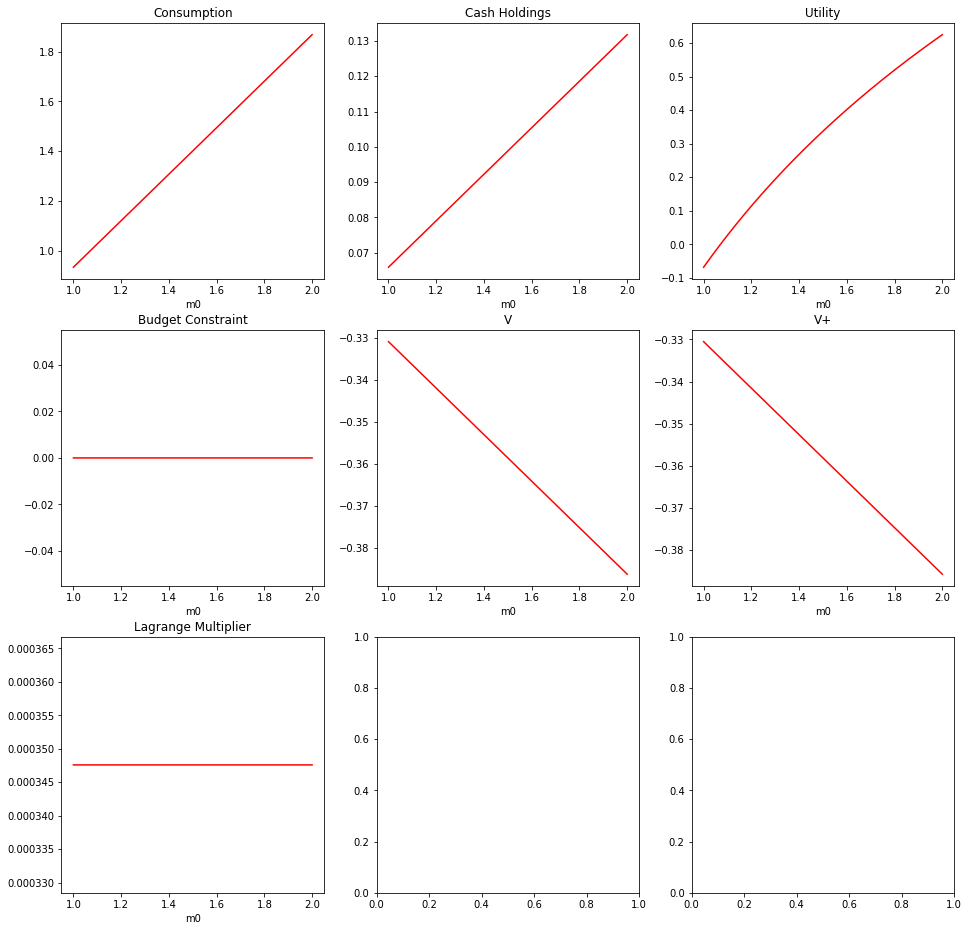

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
_ = df['rc'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='red')
_ = df['rm'].plot(kind='line', ax=axes.flatten()[1], title='Cash Holdings', c='red')
_ = df['ru'].plot(kind='line', ax=axes.flatten()[2], title='Utility', c='red')
_ = df['rbc'].plot(kind='line', ax=axes.flatten()[3], title='Budget Constraint', c='red')
_ = df['rv0'].plot(kind='line', ax=axes.flatten()[4], title='V', c='red')
_ = df['rv1'].plot(kind='line', ax=axes.flatten()[5], title='V+', c='red')
_ = df['rl0'].plot(kind='line', ax=axes.flatten()[6], title='Lagrange Multiplier', c='red')

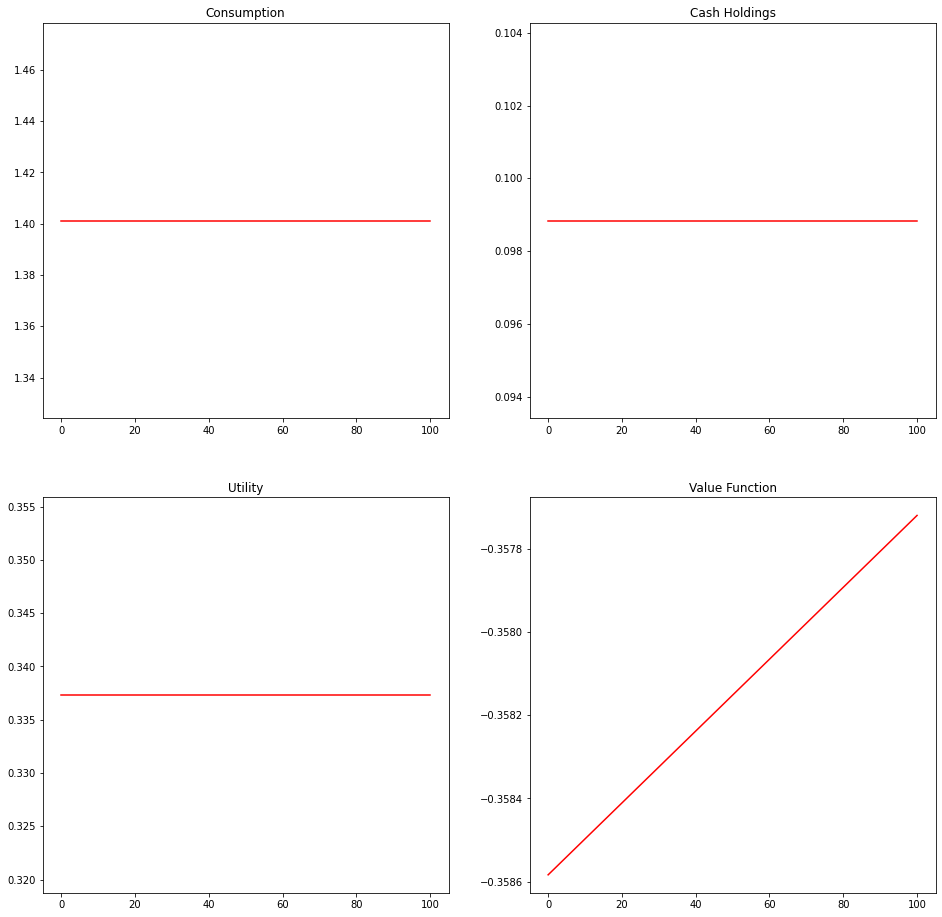

In [6]:
m0 = 1.5 * jnp.ones(1)
v0, c0, m1, bc, l0 = jax.vmap(lambda t0: neural_network(params, m0, t0))(t)
u = jax.vmap(utility)(c0)
df = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1), 
                                   m1.reshape(-1, 1), 
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), u.reshape(-1, 1)),
                                   axis=1))
df.columns = ['c', 'm', 'bc', 'v', 'u']

fig, axes = plt.subplots(2, 2, figsize=(16,16))
_ = df['c'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='red')
_ = df['m'].plot(kind='line', ax=axes.flatten()[1], title='Cash Holdings', c='red')
_ = df['u'].plot(kind='line', ax=axes.flatten()[2], title='Utility', c='red')
_ = df['v'].plot(kind='line', ax=axes.flatten()[3], title='Value Function', c='red')

In [7]:
u = -5.041695
v1 = -0.
v0 = -42632.098

((u + 0.8 * v1) / v0) - 1

-0.9998817394583771

In [8]:
live_next = jnp.int32(t0 < econ_config['T'])
jax.lax.cond(live_next[0],
             lambda _: jnp.array([1, 0]),
             lambda _: (0, 1),
             0)

TypeError: true_fun and false_fun output must have same type structure, got PyTreeDef(*) and PyTreeDef((*, *)).